In [1]:
import sys
sys.path.append('../../')

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import regression_efficacy_metrics

In [3]:
dataset = load_diabetes() # load dataset

X = dataset.data # features
y = dataset.target # target 
feature_names = dataset.feature_names # feature names

X = pd.DataFrame(X, columns=feature_names) # convert to dataframe

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'bp'}>, <Axes: title={'center': 's1'}>,
        <Axes: title={'center': 's2'}>],
       [<Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: title={'center': 's6'}>, <Axes: >, <Axes: >]], dtype=object)

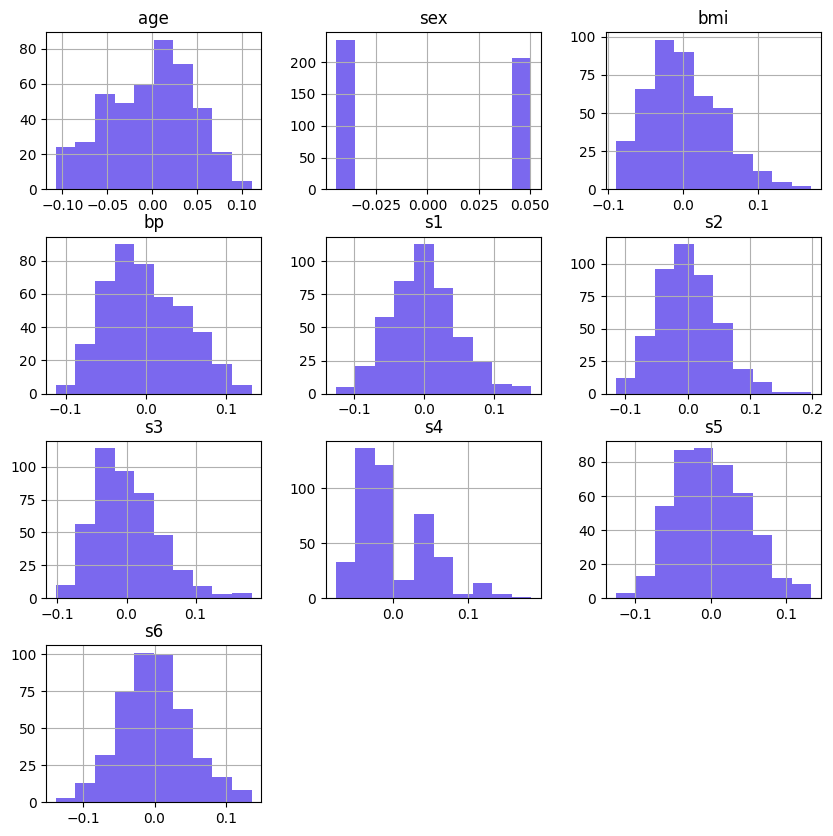

In [4]:
X.hist(bins=10, figsize=(10, 10), color = 'mediumslateblue')

<Axes: >

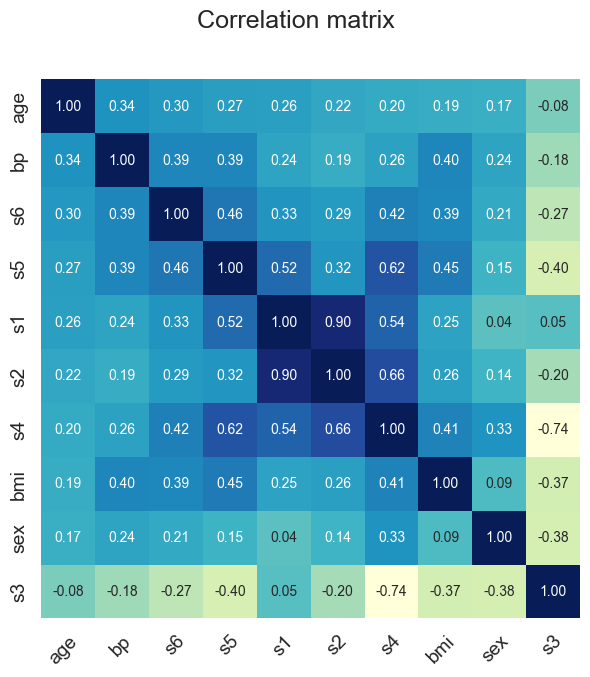

In [5]:
from holisticai.bias.plots import correlation_matrix_plot

correlation_matrix_plot(X, target_feature='age', size = (12,7))

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split


model = LinearRegression() # instantiate model
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
regression_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
RMSE,53.853446,0
MAE,42.794095,0
MAPE,0.374998,0
Max Error,154.493375,0
SMAPE,0.158513,0


In [7]:
# permutation feature importance
explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

ValueError: max_samples must be <= n_samples

In [ ]:
explainer.metrics()

In [ ]:
explainer.partial_dependence_plot()

In [ ]:
explainer.metrics(detailed=True)

In [ ]:
# How change the feature importance for each quantil with respect to the feature importance of the whole model?
explainer.contrast_visualization(show_connections=False)

In [ ]:
explainer.bar_plot(max_display=10)

# Global Explainability metrics (based on Surrogate Model)

In [ ]:
# surrogate feature importance
explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [ ]:
explainer.metrics()

In [ ]:
explainer.partial_dependence_plot()

In [ ]:
explainer.bar_plot(max_display=5)

In [ ]:
explainer.tree_visualization('sklearn')

In [ ]:
explainer.tree_visualization('graphviz')

# Local Explainability Metrics (based on Lime)

In [ ]:
# lime feature importance
explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [ ]:
explainer.metrics()

In [ ]:
explainer.bar_plot(max_display=10)

In [ ]:
a = explainer.show_importance_stability()

In [ ]:
def importance_spread(feature_importance, divergence=False):
    """
    Parameters
    ----------
    feature_importance: np.array
        array with raw feature importance
    divergence: bool
        if True calculate divergence instead of ratio
    """
    if len(feature_importance) == 0:
        return 0 if divergence else 1

    importance = feature_importance
    from scipy.stats import entropy

    feature_weight = importance / sum(importance)
    feature_equal_weight = np.array([1.0 / len(importance)] * len(importance))

    # entropy or divergence
    if divergence is False:
        return entropy(feature_weight) / entropy(feature_equal_weight)  # ratio
    else:
        return entropy(feature_weight, feature_equal_weight)  # divergence

In [ ]:
importance_spread(np.array([0.33, 0.33, 0.34]), divergence=False)

In [ ]:
from holisticai.explainability.metrics.feature_importance.local_importance._local_metrics import (
    dataset_spread_stability,
    features_spread_stability,
)

def show_importances(group):
    all_fimp = explainer.explainer_handler.get_topk(None)
    data_stability = dataset_spread_stability(**all_fimp)
    #feature_stability = features_spread_stability(**kargs)    
    
    spread = data_stability['imp_spread'][group]
    cfimp = all_fimp['conditional_feature_importance']
    fimp = all_fimp['feature_importance'].groupby('Feature Label')['Importance'].mean()
    
    fig,axs = plt.subplots(1,3)

    def show_importance(feature_importance, index, ax):  
        Q=feature_importance
        qs = Q[Q['Sample Id']==index]
        qs.set_index('Feature Label')['Importance'].sort_values(ascending=True).plot(kind='barh', figsize=(10,5), color='mediumslateblue',ax=ax)
    
    max_index = spread.idxmax()
    min_index = spread.idxmin()
    
    fimp.sort_values(ascending=True).plot(kind='barh', figsize=(10,5), color='mediumslateblue',ax=axs[0])
    axs[0].set_title('Average')
    show_importance(cfimp[group], min_index, axs[1])
    axs[1].set_title(f'Min Spread Ratio [{spread.loc[min_index]:.3f}]')
    show_importance(cfimp[group], max_index, axs[2])
    axs[2].set_title(f'Max Spread Ratio [{spread.loc[max_index]:.3f}]')


In [ ]:
group = '[Q0-Q1]'
show_importances(group)